In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
g = torch.Generator().manual_seed(42) # reproducibility

In [3]:
# building the dataset
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)

block_size = 3  # context size: how many characters we consider to predict the next character

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # update context with the next character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1]) # training set
Xdev, Ydev = build_dataset(words[n1:n2]) # validation set
Xte, Yte = build_dataset(words[n2:]) # test set

In [4]:
# utility function to compare manual gradients with pytorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item() # exact match
    app = torch.allclose(dt, t.grad) # approximate match
    maxdiff = (dt - t.grad).abs().max().item() # max difference
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff={maxdiff}')

In [5]:
# initialize the parameters
n_emb = 10 # embedding size
n_hidden = 64 # hidden layer size

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g) # embedding matrix
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size) ** 0.5) # first layer initialized with small values, scaled down
b1 = torch.randn((n_hidden), generator=g) * 0.1 # bias for the first layer
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1 # second layer, initialized with small values, scaled down
b2 = torch.randn((vocab_size), generator=g) * 0.1 # bias for the second layer, initialized to zero at the beginning

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0 # batch normalization gain
bnbias = torch.randn((1, n_hidden)) * 0.1 # batch normalization bias

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print('Number of parameters:', sum(p.numel() for p in parameters))

for p in parameters:
    p.requires_grad = True

Number of parameters: 4137


In [6]:
batch_size = 32
n = batch_size # for convenience
# construct a mini-batch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # random indices
Xb, Yb = Xtr[ix], Ytr[ix] # the mini-batch

In [8]:
# forward pass, chunkated into smaller steps so its easy to perform backward pass
emb = C[Xb] # embedding 
embcat = emb.view(emb.shape[0], -1) # concatenate the embeddings
# Linear layer
hprebn = embcat @ W1 + b1 # linear transformation

# Batch normalization
bnmeani = 1/n*hprebn.sum(0, keepdim=True) # mean
bndiff = hprebn - bnmeani # difference
bndiff2 = bndiff ** 2 # squared difference
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True) # variance, bessels correction, n-1 and not n
bnvar_inv = (bnvar + 1e-5)**-0.5 # inverse square root, with epsilon for numerical stability
bnraw = bndiff * bnvar_inv # normalized input
hpreact = bngain * bnraw + bnbias # scale and shift

# Non-linearity
h = torch.tanh(hpreact) # non-linearity

# Second linear layer
logits = h @ W2 + b2 # logits

# Loss
# same as F.cross_entropy(logits, Yb) # cross-entropy loss
logit_maxes = logits.max(1, keepdim=True).values # max value of each row
norm_logits = logits - logit_maxes # subtract the max value for numerical stability
counts = norm_logits.exp() # exponentiate
counts_sum = counts.sum(1, keepdim=True) # sum of exponentiated values
counts_sum_inv = counts_sum ** -1 # inverse
probs = counts * counts_sum_inv # probabilities
logprobs = probs.log() # log-probabilities
loss = -logprobs[range(n), Yb].mean() # cross-entropy loss

# backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn, embcat, emb]:
    t.retain_grad() # we need to retain the gradients for these tensors
loss.backward()
loss

tensor(3.4257, grad_fn=<NegBackward0>)

In [ ]:
# manual computation of gradients
############################ logprobs ############################
logprobs.shape # (32, 27)
Yb # index of the correct character
logprobs[range(n), Yb] # indices of the correct characters
logprobs[range(n), Yb].mean() # loss

# loss = -(a + b + c)/3
# loss = -1/3a - 1/3b - 1/3c
# dloss/da = -1/3
# dloss/db = -1/3
# dloss/dc = -1/3
dloss = -1/n # gradient of the loss with respect to the average of the log-probabilities
# remember that the derivative of loss w.r.t to numbers which do not get pluked out of large array doesnt matter, becuase they do not contribute to the loss

############################ probs ############################
# dloss/dprobs = dlogprobs * dprobs # chain rule
# dprobs = 1/probs

############################ counts_sum_inv & counts ############################
# dloss/dcounts_sum_inv = dprobs * dcounts_sum_inv
# dcounts_sum_inv = counts
counts.shape, counts_sum_inv.shape # (32, 27), (32, 1), broadcasting will be used
# c = a * b, but with tensors
# a[3*3], b[3*1] -->
# a11 * b11, a12 * b11, a13 * b11
# a21 * b11, a22 * b11, a23 * b11
# a31 * b11, a32 * b11, a33 * b11
# c[3*3]
# two operations happen here, replication during broadcasting and then multiplication
# remember that b11 is replicated 3 times, and then multiplied with a11, a12, a13, so we take sum the derivatives of c w.r.t to a11, a12, a13

# dloss/dcounts = dprobs * dcounts
# dcounts = counts_sum_inv
# remeber not to cmp dcounts, since this is just the first contribution of counts, there will be another contribution

############################ counts_sum ############################
# dloss/dcounts_sum = dcounts_sum_inv * dcounts_sum
# dcounts_sum = -1/counts_sum^2

############################ counts ############################
# dloss/dcounts = dcounts_sum * dcounts
# dcounts = 
counts.shape, counts_sum.shape # (32, 27), (32, 1), broadcasting will be used
# a11 a12 a13 ---> b1 (= a11 + a12 + a13)
# a21 a22 a23 ---> b2 (= a21 + a22 + a23)
# a31 a32 a33 ---> b3 (= a31 + a32 + a33)

############################ norm_logits & logits ############################
# dloss/dnorm_logits = dcounts * dnorm_logits
# dnorm_logits = 1

############################ norm_logits ############################
norm_logits.shape, logits.shape, logit_maxes.shape # (32, 27), (32, 1), broadcasting will be used

# c11 c12 c13 ---> a11 a12 a13    b1
# c21 c22 c23 ---> a21 a22 a23 -  b2
# c31 c32 c33 ---> a31 a32 a33    b3

# c32 = a32 - b3
# derivatives of c w.r.t a will be 1's and w.r.t b will be -1's. Therfore, c flows as it is, and a flows as it is, but b flows with a negative sign (sum for )

############################ logits ############################
# dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # gradient of the loss with respect to the logitsx

# see how the max of the logits is displayed
# plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))


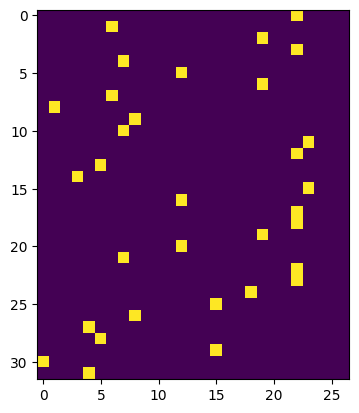

In [16]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [15]:
# Lets calculate the gradients manually
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n # gradient of the loss with respect to the log-probabilities

dprobs = (1.0/probs) * dlogprobs # chain rule

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # sum of the gradients of the loss with respect to the sum of the exponentiated values
dcounts = counts_sum_inv * dprobs # gradient of the loss with respect to the exponentiated values, broadcasting will be used here
# remeber not to cmp dcounts, since this is just the first contribution of counts, there will be another contribution

dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv # gradient of the loss with respect to the sum of the exponentiated values
dcounts += torch.ones_like(counts) * dcounts_sum

dnorm_logits = torch.exp(norm_logits) * dcounts # gradient of the loss with respect to the normalized logits

# derivatives of c w.r.t a will be 1's and w.r.t b will be -1's. Therfore, c flows as it is, and a flows as it is, but b flows with a negative sign (sum for )
dlogits = dnorm_logits.clone() # gradient of the loss with respect to the logits
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # gradient of the loss with respect to the max values

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # gradient of the loss with respect to the logitsx

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('dlogits', dlogits, logits)

logprobs        | exact: True  | approximate: True  | maxdiff=0.0
probs           | exact: True  | approximate: True  | maxdiff=0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff=0.0
counts_sum      | exact: True  | approximate: True  | maxdiff=0.0
counts          | exact: True  | approximate: True  | maxdiff=0.0
norm_logits     | exact: True  | approximate: True  | maxdiff=0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff=0.0
dlogits         | exact: True  | approximate: True  | maxdiff=0.0
